In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
from xgboost import XGBClassifier
from imblearn.over_sampling import RandomOverSampler, SMOTE
import seaborn as sns
import matplotlib.pyplot as plt

In [8]:
pre_df = pd.read_csv('../data/cleaned/cleaned_vessel_calls.csv')

In [9]:
# Preprocess dataframe - duration and month
pre_df["arrivalDate"] = pd.to_datetime(pre_df["arrivalDate"])
pre_df["sailingDate"] = pd.to_datetime(pre_df["sailingDate"])
pre_df["duration"] = pd.to_datetime(pre_df["sailingDate"]) - pd.to_datetime(pre_df["arrivalDate"])
pre_df["month"] = pre_df["arrivalDate"].dt.month

pre_df['duration'] = pre_df['duration'] / pd.Timedelta(days=1)

# Drop null values in df
pre_df.dropna(inplace=True)

# Preprocess data
pre_df.sort_values(by=["IMO", "arrivalDate"], inplace=True)
pre_df['next_unlocode'] = pre_df.groupby('IMO')['place.unlocode'].shift(-1)
pre_df['is_last_imo'] = pre_df['IMO'] != pre_df['IMO'].shift(-1)
pre_df = pre_df[~pre_df["is_last_imo"]]
pre_df = pre_df[pre_df["Event_Type"] != "ARRIVAL"]

pre_df = pre_df.drop(columns=["is_last_imo", "Event_Type", "Timestamp", "vessel.vesselName", "IMO", "arrivalDate", "sailingDate"])

df = pre_df.rename(columns={'place.unlocode':'current_unlocode', 'place.placeName':'port_name','vessel.vesselType':'vessel_type', 'place.placeType': 'place_type', 'place.countryName': 'country_name'})

In [10]:
# Calculate frequency of each port for thresholding
port_counts = pd.concat([df['current_unlocode'], df['next_unlocode']]).value_counts()

threshold = 1000

# Filter ports that meet the threshold
valid_ports_df = port_counts[port_counts >= threshold]
valid_ports = port_counts[port_counts >= threshold].index

# Keep only rows where both current and next ports are in valid_ports
filtered_df = df[(df['current_unlocode'].isin(valid_ports)) & (df['next_unlocode'].isin(valid_ports))]

# Select a certain number of samples for each port
rows_to_add = []
port_usage = {port: 0 for port in valid_ports}
filtered_df = filtered_df.sample(frac=1, random_state=42)

for _, row in filtered_df.iterrows():
    current_port = row['current_unlocode']
    next_port = row['next_unlocode']
    if port_usage[current_port] < 200 and port_usage[next_port] < 200:
        rows_to_add.append(row)
        port_usage[current_port] += 1
        port_usage[next_port] += 1
        if all(count >= 100 for count in port_usage.values()):
            break

balanced_df = pd.DataFrame(rows_to_add)
balanced_df = balanced_df.reset_index(drop=True)

df_bal_counts = pd.concat([balanced_df['current_unlocode'], balanced_df['next_unlocode']]).value_counts()

threshold = 200
valid_ports_bal_df = df_bal_counts[df_bal_counts >= threshold]
valid_ports_bal = df_bal_counts[df_bal_counts >= threshold].index
filtered_bal_df = balanced_df[(balanced_df['current_unlocode'].isin(valid_ports_bal)) & (balanced_df['next_unlocode'].isin(valid_ports_bal))]

df = filtered_bal_df

In [11]:
# Encode categorical features
label_encoders = {}
for column in ['port_name', 'place_type', 'vessel_type', 'country_name']:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column].astype(str))
    label_encoders[column] = le

all_ports = pd.concat([df['current_unlocode'], df['next_unlocode']])
unique_ports = all_ports.unique()
port_to_id = {port: i for i, port in enumerate(unique_ports)}

df['encoded_current_unlocode'] = df['current_unlocode'].map(port_to_id)
df['encoded_next_unlocode'] = df['next_unlocode'].map(port_to_id)

df = df.drop(columns=['current_unlocode', 'next_unlocode', 'place_type'])

C:\Users\syeda\AppData\Local\Temp\ipykernel_18620\3580997444.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = le.fit_transform(df[column].astype(str))
C:\Users\syeda\AppData\Local\Temp\ipykernel_18620\3580997444.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = le.fit_transform(df[column].astype(str))
C:\Users\syeda\AppData\Local\Temp\ipykernel_18620\3580997444.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

In [12]:
results = {}

min_samples_per_class = 2

# Split the data by country and vessel type
grouped = df.groupby(['country_name', 'vessel_type'])

for (country, vessel_type), group_df in grouped:
    if len(group_df) < 50:  # Skip groups with too few entries
        print(f"Skipping country: {country}, vessel type: {vessel_type}")
        continue
    
    print(f"Processing country: {country}, vessel type: {vessel_type}")
    
    # Prepare features and target variable
    X = group_df.drop(columns=['encoded_next_unlocode', 'country_name', 'vessel_type'])
    y = group_df['encoded_next_unlocode']

    # Ensure the target variable y is sequentially encoded
    le_y = LabelEncoder()
    y = le_y.fit_transform(y)
    
    class_counts = pd.Series(y).value_counts()
    
    if class_counts.min() < min_samples_per_class:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
    else:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
    
    # Use SMOTE to handle class imbalance
    if class_counts.min() < 6:
        print(f"Using RandomOverSampler for {country} - {vessel_type}")
        resampler = RandomOverSampler(random_state=42)
    else:
        print(f"Using SMOTE for {country} - {vessel_type}")
        resampler = SMOTE(random_state=42, k_neighbors=min(class_counts.min() - 1, 5))
    
    X_train, y_train = resampler.fit_resample(X_train, y_train)
    
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # Move data to GPU
    X_train = pd.DataFrame(X_train).values
    X_test = pd.DataFrame(X_test).values

    # Define the model and parameter grid for XGBoost
    model = XGBClassifier(random_state=42, eval_metric='mlogloss')
    param_distributions = {
        'n_estimators': [100, 150, 200, 250, 300],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'max_depth': [3, 4, 5, 6],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0]
    }
    
    skf = StratifiedKFold(n_splits=3) if class_counts.min() >= min_samples_per_class else None
    random_search = RandomizedSearchCV(estimator=model, param_distributions=param_distributions, cv=skf, verbose=2, n_jobs=-1, scoring='accuracy', error_score='raise', n_iter=50)
    
    try:
        random_search.fit(X_train, y_train)
        best_model = random_search.best_estimator_
    except Exception as e:
        print(f"Error training XGBoost for {country} - {vessel_type}: {e}")
        continue
    
    train_predictions = best_model.predict(X_train)
    test_predictions = best_model.predict(X_test)
    
    training_accuracy = accuracy_score(y_train, train_predictions) * 100
    validation_accuracy = accuracy_score(y_test, test_predictions) * 100
    
    print(f'Training Accuracy for {country} - {vessel_type}: {training_accuracy}')
    print(f'Validation Accuracy for {country} - {vessel_type}: {validation_accuracy}')
    print(f'Best Model for {country} - {vessel_type}: {best_model}')
    
    classification_rep = classification_report(y_test, test_predictions, output_dict=True)
    
    results[(country, vessel_type)] = {
        'training_accuracy': training_accuracy,
        'validation_accuracy': validation_accuracy,
        'best_model': best_model,
        'classification_report': classification_rep,
        'num_entries': len(X_test)
    }

Skipping country: 0, vessel type: 0
Skipping country: 0, vessel type: 3
Skipping country: 0, vessel type: 5
Skipping country: 0, vessel type: 6
Skipping country: 0, vessel type: 7
Skipping country: 0, vessel type: 12
Skipping country: 0, vessel type: 14
Skipping country: 1, vessel type: 0
Skipping country: 1, vessel type: 4
Skipping country: 1, vessel type: 5
Skipping country: 1, vessel type: 7
Skipping country: 1, vessel type: 9
Skipping country: 1, vessel type: 10
Skipping country: 1, vessel type: 12
Processing country: 1, vessel type: 14
Using RandomOverSampler for 1 - 14
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Error training XGBoost for 1 - 14: Invalid classes inferred from unique values of `y`.  Expected: [0 1 2 3 4 5 6 7], got [0 1 2 3 4 6 8 9]
Skipping country: 2, vessel type: 0
Skipping country: 2, vessel type: 4
Skipping country: 2, vessel type: 5
Skipping country: 2, vessel type: 6
Skipping country: 2, vessel type: 7
Skipping country: 2, vessel type: 10


c:\Users\syeda\OneDrive\Documents\American Bureau of Shipping\projects\ais_port_prediction\nn_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\syeda\OneDrive\Documents\American Bureau of Shipping\projects\ais_port_prediction\nn_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\syeda\OneDrive\Documents\American Bureau of Shipping\projects\ais_port_prediction\nn_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and bein

Error training XGBoost for 5 - 14: Invalid classes inferred from unique values of `y`.  Expected: [0 1 2 3 4 5], got [1 2 3 6 7 8]
Skipping country: 6, vessel type: 0
Skipping country: 6, vessel type: 6
Processing country: 6, vessel type: 7
Using RandomOverSampler for 6 - 7
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Error training XGBoost for 6 - 7: Invalid classes inferred from unique values of `y`.  Expected: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13], got [ 0  1  2  3  4  5  6  7  8 10 11 12 13 14]
Skipping country: 6, vessel type: 14
Processing country: 7, vessel type: 7
Using RandomOverSampler for 7 - 7
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Training Accuracy for 7 - 7: 100.0
Validation Accuracy for 7 - 7: 35.59322033898305
Best Model for 7 - 7: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=Non

c:\Users\syeda\OneDrive\Documents\American Bureau of Shipping\projects\ais_port_prediction\nn_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\syeda\OneDrive\Documents\American Bureau of Shipping\projects\ais_port_prediction\nn_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\syeda\OneDrive\Documents\American Bureau of Shipping\projects\ais_port_prediction\nn_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to

Error training XGBoost for 8 - 7: Invalid classes inferred from unique values of `y`.  Expected: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14], got [ 0  1  2  3  4  5  6  9 10 11 12 13 14 15 16]
Skipping country: 8, vessel type: 9
Skipping country: 8, vessel type: 10
Processing country: 8, vessel type: 14
Using RandomOverSampler for 8 - 14
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Error training XGBoost for 8 - 14: Invalid classes inferred from unique values of `y`.  Expected: [ 0  1  2  3  4  5  6  7  8  9 10 11 12], got [ 0  2  3  4  5  6  7  9 10 11 12 13 14]
Skipping country: 9, vessel type: 0
Skipping country: 9, vessel type: 5
Processing country: 9, vessel type: 7
Using RandomOverSampler for 9 - 7
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Error training XGBoost for 9 - 7: Invalid classes inferred from unique values of `y`.  Expected: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23], got [ 0  1  2  3  4  5  6  7  8 

c:\Users\syeda\OneDrive\Documents\American Bureau of Shipping\projects\ais_port_prediction\nn_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\syeda\OneDrive\Documents\American Bureau of Shipping\projects\ais_port_prediction\nn_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\syeda\OneDrive\Documents\American Bureau of Shipping\projects\ais_port_prediction\nn_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to

Error training XGBoost for 14 - 7: Invalid classes inferred from unique values of `y`.  Expected: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23], got [ 1  2  3  4  5  6  7  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25]
Skipping country: 14, vessel type: 9
Processing country: 14, vessel type: 12
Using RandomOverSampler for 14 - 12
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Error training XGBoost for 14 - 12: Invalid classes inferred from unique values of `y`.  Expected: [0 1 2 3 4], got [ 0  1  3  7 10]
Processing country: 14, vessel type: 14
Using RandomOverSampler for 14 - 14
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Error training XGBoost for 14 - 14: Invalid classes inferred from unique values of `y`.  Expected: [ 0  1  2  3  4  5  6  7  8  9 10 11 12], got [ 0  1  3  4  6  7  8  9 10 11 12 13 14]
Skipping country: 15, vessel type: 0
Skipping country: 15, vessel type: 5
Skipping country: 15, vessel type: 6
Proces

c:\Users\syeda\OneDrive\Documents\American Bureau of Shipping\projects\ais_port_prediction\nn_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\syeda\OneDrive\Documents\American Bureau of Shipping\projects\ais_port_prediction\nn_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\syeda\OneDrive\Documents\American Bureau of Shipping\projects\ais_port_prediction\nn_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to

Error training XGBoost for 17 - 7: Invalid classes inferred from unique values of `y`.  Expected: [ 0  1  2  3  4  5  6  7  8  9 10 11 12], got [ 0  1  2  4  5  7  9 10 12 13 14 15 16]
Skipping country: 17, vessel type: 12
Processing country: 18, vessel type: 7
Using RandomOverSampler for 18 - 7
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Error training XGBoost for 18 - 7: Invalid classes inferred from unique values of `y`.  Expected: [0 1 2 3], got [0 3 5 6]
Skipping country: 18, vessel type: 9
Skipping country: 18, vessel type: 14
Skipping country: 19, vessel type: 0
Skipping country: 19, vessel type: 6
Processing country: 19, vessel type: 7
Using RandomOverSampler for 19 - 7
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Error training XGBoost for 19 - 7: Invalid classes inferred from unique values of `y`.  Expected: [0 1 2 3 4 5 6 7 8 9], got [ 0  1  2  3  4  5  9 11 12 14]
Skipping country: 19, vessel type: 8
Skipping country: 19, vessel type: 12
S


Results for 3 - 6:
Number of entries: 32
Training Accuracy: 100.0
Validation Accuracy: 87.5
Best Model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=250,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)


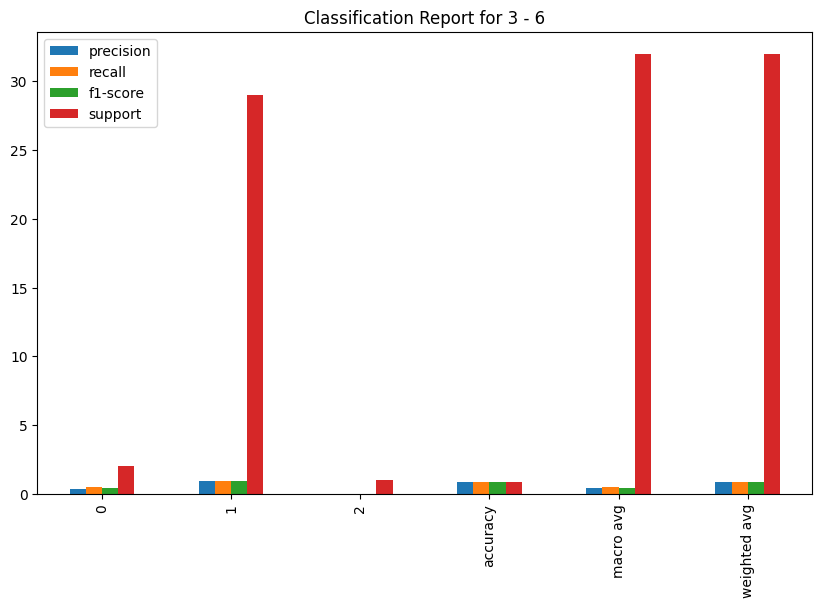

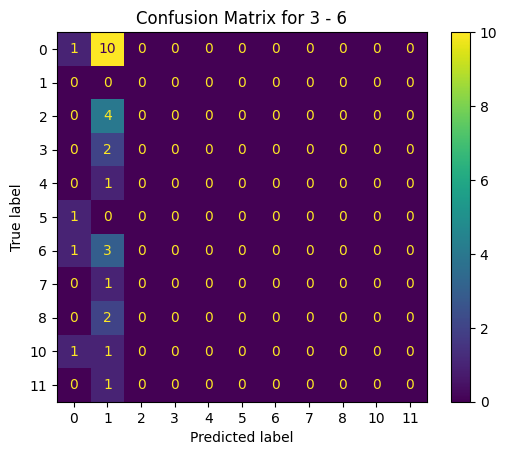


Results for 14 - 5:
Number of entries: 30
Training Accuracy: 100.0
Validation Accuracy: 40.0
Best Model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=250,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)


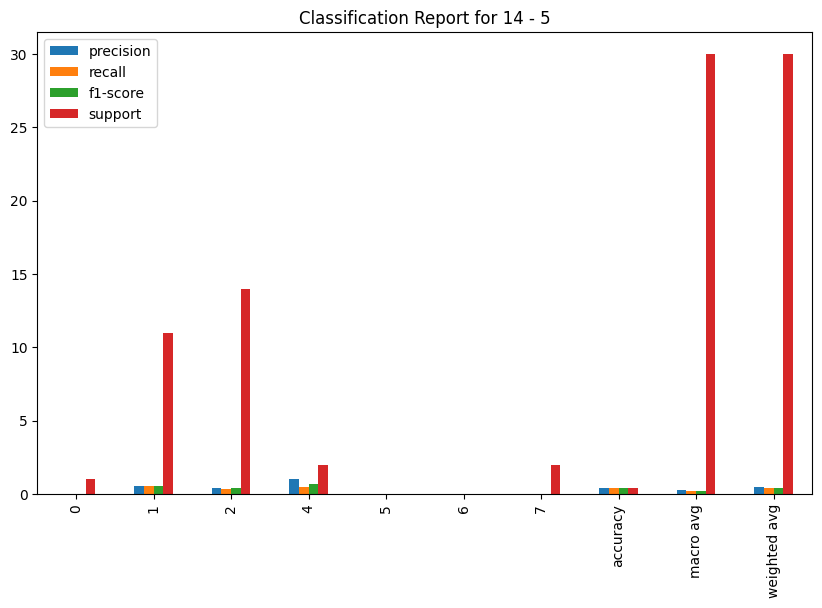

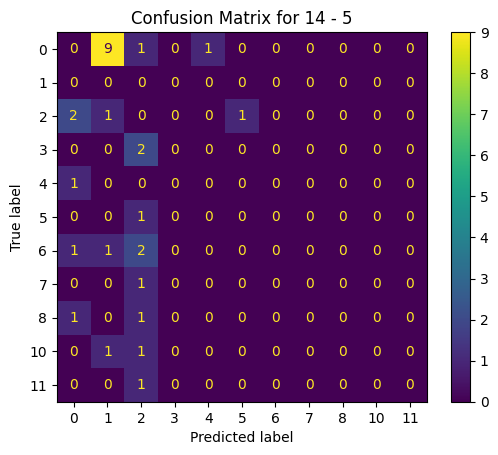


Results for 7 - 7:
Number of entries: 59
Training Accuracy: 100.0
Validation Accuracy: 35.59322033898305
Best Model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=250,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)


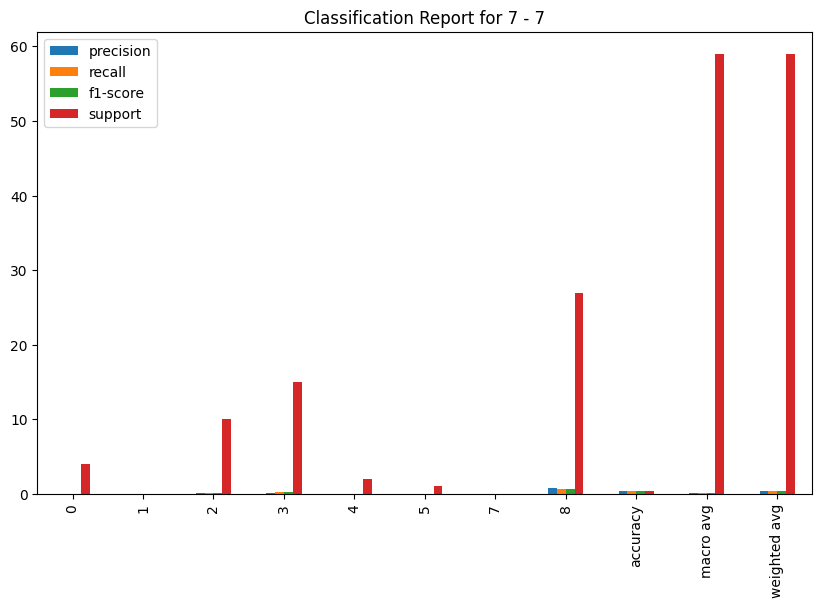

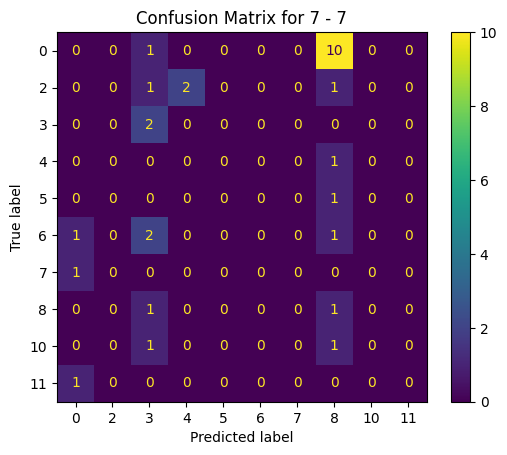


Results for 16 - 7:
Number of entries: 38
Training Accuracy: 100.0
Validation Accuracy: 31.57894736842105
Best Model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=250,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)


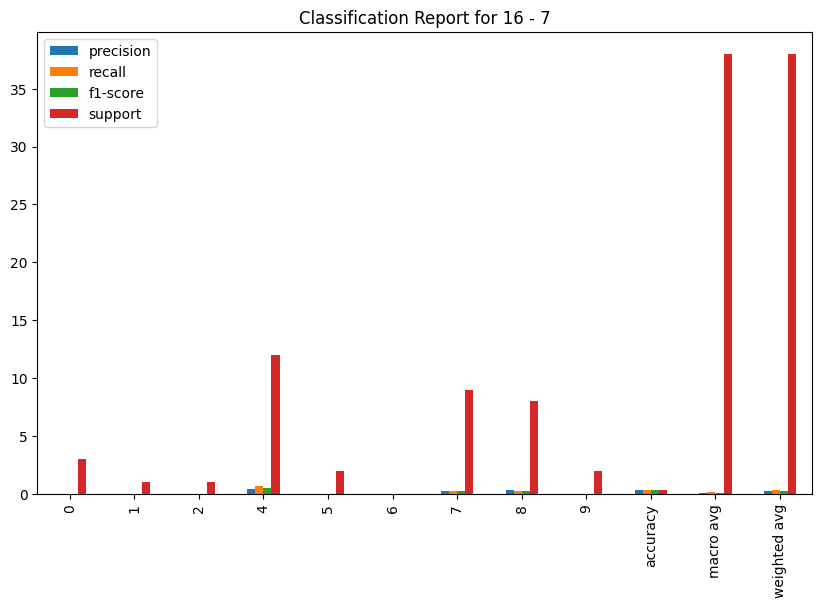

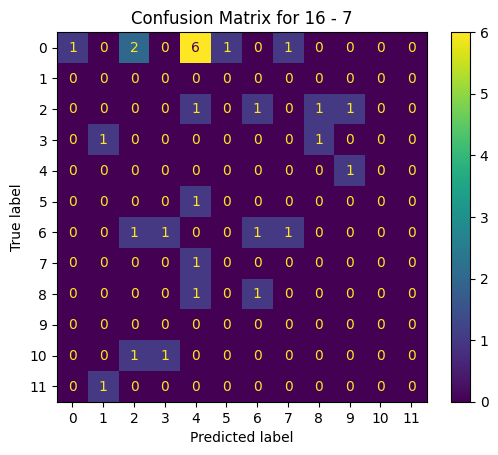

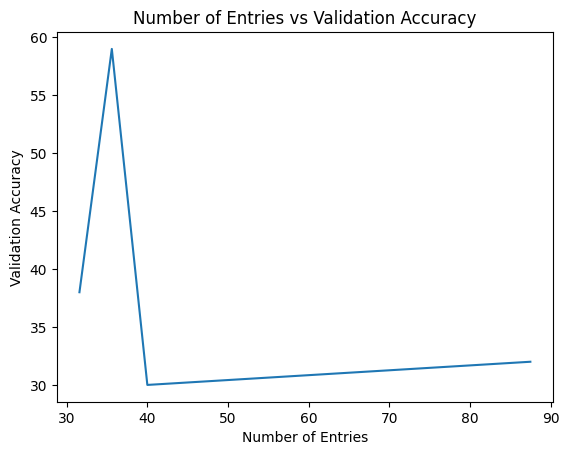

In [13]:
best_results = sorted(results.items(), key=lambda x: x[1]['validation_accuracy'], reverse=True)

# Visualization
for (country, vessel_type), result in best_results:
    print(f"\nResults for {country} - {vessel_type}:")
    print(f"Number of entries: {result['num_entries']}")
    print(f"Training Accuracy: {result['training_accuracy']}")
    print(f"Validation Accuracy: {result['validation_accuracy']}")
    print(f"Best Model: {result['best_model']}")
    
    classification_rep_df = pd.DataFrame(result['classification_report']).transpose()
    classification_rep_df.plot(kind='bar', figsize=(10, 6), title=f'Classification Report for {country} - {vessel_type}')
    plt.show()
    
    ConfusionMatrixDisplay.from_estimator(result['best_model'], X_test, y_test)
    plt.title(f'Confusion Matrix for {country} - {vessel_type}')
    plt.show()

if best_results:
    best_country_vessel_type = best_results[0][0]
    best_model = best_results[0][1]['best_model']
    best_classification_report = best_results[0][1]['classification_report']

    # Plot validation accuracy vs number of entries
    plt.plot([result['validation_accuracy'] for _, result in best_results], [result['num_entries'] for _, result in best_results])
    plt.xlabel('Number of Entries')
    plt.ylabel('Validation Accuracy')
    plt.title('Number of Entries vs Validation Accuracy')
    plt.show()
else:
    print("No valid results found.")

In [14]:
# Convert vessel type and country name to their original values
best_country, best_vessel_type = best_country_vessel_type
best_country = label_encoders['country_name'].inverse_transform([best_country])[0]
best_vessel_type = label_encoders['vessel_type'].inverse_transform([best_vessel_type])[0]
print(f"Best Model: {best_model}")
print(f"Best Country: {best_country}")
print(f"Best Vessel Type: {best_vessel_type}")

Best Model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=250,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)
Best Country: Ecuador
Best Vessel Type: crude oil tanker
